<a href="https://colab.research.google.com/github/LucasAfa/Projeto2-IF775/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import linear_model, ensemble, datasets, model_selection, preprocessing as pre
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import sklearn.metrics
from sklearn.metrics import r2_score

import matplotlib as mpl

!pip install optuna --quiet
import optuna

In [ ]:
#Fazendo a instalação e configuração do MLFlow

!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

get_ipython().system_raw("mlflow ui --port 5000 &")


from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://3a27ea3bd5a0.ngrok.io


In [ ]:
#Pegando o csv que será usado para as analises
#É um csv que contém informações sobre todos os jogadores de futebol presentes no jogo Fifa 20
fifa20=pd.read_csv("https://raw.githubusercontent.com/LucasAfa/Projeto2-IF775/main/players_20.csv", header=0)
fifa20

       sofifa_id                                         player_url  ...   rcb    rb
0         158023  https://sofifa.com/player/158023/lionel-messi/...  ...  52+2  63+2
1          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...  ...  53+3  61+3
2         190871  https://sofifa.com/player/190871/neymar-da-sil...  ...  46+3  61+3
3         200389  https://sofifa.com/player/200389/jan-oblak/20/...  ...   NaN   NaN
4         183277  https://sofifa.com/player/183277/eden-hazard/2...  ...  49+3  61+3
...          ...                                                ...  ...   ...   ...
18273     245006  https://sofifa.com/player/245006/shuai-shao/20...  ...  46+2  45+2
18274     250995  https://sofifa.com/player/250995/mingjie-xiao/...  ...  47+2  46+2
18275     252332  https://sofifa.com/player/252332/wei-zhang/20/...  ...  49+2  47+2
18276     251110  https://sofifa.com/player/251110/haijian-wang/...  ...  49+2  48+2
18277     233449  https://sofifa.com/player/233449/ximing-pan/20.

In [ ]:
#Não pretendemos analisar os goleiros, pois muitas colunas deles são vazias e ter que inputar dados em todas elas não soa muito interessante pra gente
fifa20 = fifa20[(fifa20.team_position != "GK")]
fifa20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,91,91,90000000,370000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,166500000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,...,76,61,88,94,79,91,68,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


In [ ]:
#Tornando algumas colunas categóricas e encodando elas, pois podem ser relevantes para a analise
fifa20['nationality'] = fifa20['nationality'].astype('category')
fifa20['club'] = fifa20['club'].astype('category')
fifa20['team_position'] = fifa20['team_position'].astype('category')

fifa20['team_position'] = fifa20['team_position'].cat.codes
fifa20['country_code'] = fifa20['nationality'].cat.codes
fifa20['club_code'] = fifa20['club'].cat.codes

fifa20 = fifa20._get_numeric_data()


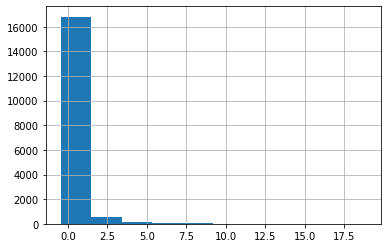

In [ ]:
#Pretendemos fazer a predição do valor do jogador, e para isso precisamos desse valor normalizado
fifa20['price_norm'] = (fifa20['value_eur'] - fifa20['value_eur'].mean()) / (fifa20['value_eur'].std())
fifa20.price_norm.hist()

In [ ]:
#Aqui estamos dropando colunas com 70% dos dados ausentes que não serão relevantes 
fifa20 = fifa20.dropna(thresh=0.7*len(fifa20), axis=1)
fifa20.describe


<bound method NDFrame.describe of        sofifa_id  age  height_cm  ...  country_code  club_code  price_norm
0         158023   32        170  ...             5        224   17.005348
1          20801   34        187  ...           120        350   10.244419
2         190871   27        175  ...            18        462   18.832626
4         183277   28        175  ...            12        505   16.000345
5         192985   28        181  ...            12        400   16.000345
...          ...  ...        ...  ...           ...        ...         ...
18273     245006   22        186  ...            28         79   -0.437849
18274     250995   22        177  ...            28        574   -0.437849
18275     252332   19        186  ...            28        317   -0.437849
18276     251110   18        185  ...            28        573   -0.437849
18277     233449   26        182  ...            28        317   -0.437849

[17616 rows x 58 columns]>

In [ ]:
#Essa coluna nos será relevante, porém possui alguns dados ausentes, então estamos preenchendo os vazios com a média
fifa20['release_clause_eur'].fillna(fifa20['release_clause_eur'].mean(), inplace=True)


In [ ]:
#Vamos aqui subdivir os grupos de teste e treino de forma aleatória para o nosso dataframe usando o train_test_split
X, y = fifa20, fifa20['price_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8,random_state=9,)

print(f"Train labels:\n{y_train}")
print(f"Test labels:\n{y_test}")
print(f"Train labels:\n{X_train}")
print(f"Test labels:\n{X_test}")

Train labels:
11384   -0.330953
13026   -0.390340
10328   -0.308112
1789     1.108028
13140   -0.330953
           ...   
4812     0.103025
4957    -0.043157
5323    -0.285271
10501   -0.335521
564      1.473484
Name: price_norm, Length: 14092, dtype: float64
Test labels:
7605    -0.280703
369      1.016665
1530     0.742573
3821    -0.289839
13986   -0.349226
           ...   
12369   -0.340089
1537     0.742573
1488     0.925301
11669   -0.340089
7951    -0.271567
Name: price_norm, Length: 3524, dtype: float64
Train labels:
       sofifa_id  age  height_cm  ...  country_code  club_code  price_norm
11384     205145   24        183  ...           127        106   -0.330953
13026     216134   29        175  ...            40         21   -0.390340
10328     240891   23        172  ...            57        233   -0.308112
1789      206594   24        180  ...            45         99    1.108028
13140     251341   18        177  ...            53        448   -0.330953
...          ...  

In [ ]:
#Aqui estamos subdividindo novamente, porém dentro dos dataframes de treino agora, para criarmos os splits de validação 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25,train_size=0.75,random_state=9,)


In [ ]:
#Vamos avaliar agora as correlações, a coluna que queremos prever é a de price_norm, referente ao value_eur, que é o valor do jogador agora normalizado
#E observando encontramos as seguintes colunas relevantes: wage_eur(Salário), overall(Força atual), mentality_composure(Mentalidade),
#potential(Potencial), international_reputation(Reputação internacional), movement_reactions(Reação de movimentos)


corr = fifa20.corr()
corr.style.background_gradient(cmap='coolwarm')


In [ ]:
#Aqui estamos criando os experimentos para serem acessados e acompanhados no MLFlow
#Os algoritmos escolhidos foram o Linear Regression, Random Forest Regressor, SVR e MLP
try:
    experiment_id_LinearRegression = mlflow.create_experiment(name="LinearRegression")
    experiment_id_RandomForest = mlflow.create_experiment(name="RandomForestRegressor")
    experiment_id_SVR = mlflow.create_experiment(name="SVR")
    experiment_id_MLP = mlflow.create_experiment(name="MLP")

except:
    experiment_id_LinearRegression = mlflow.get_experiment_by_name(name="LinearRegression").experiment_id
    experiment_id_RandomForest = mlflow.get_experiment_by_name(name="RandomForestRegressor").experiment_id
    experiment_id_SVR = mlflow.get_experiment_by_name(name="SVR").experiment_id
    experiment_id_MLP = mlflow.get_experiment_by_name(name="MLP").experiment_id

In [ ]:
'''Estávamos tendo problemas de r2 negativo no MLP, ao pesquisar para resolver encontramos que o possível motivo seria normalização dos dados. 
Era recomendado o uso do Standard Scaler para fazer isto de maneira rápida e precisa e seu uso resolveu este problema. 
Após usá-lo para o MLP, percebemos que pela natureza vetorial do SVR ele também se beneficiaria de tal mudança pela normalização facilitar a 
inserção de vetores com boa separação dos dados e resolvemos deixar os dados normalizados como o padrão pelo Standard Scaler
'''
columns = ['wage_eur', 'overall','mentality_composure','potential','international_reputation','movement_reactions']

scaler = pre.StandardScaler()
X_train = scaler.fit_transform(X_train[columns])
X_val = scaler.fit_transform(X_val[columns])
X_test = scaler.fit_transform(X_test[columns])



R2:      0.786
MSE:     0.180
MAE:     0.235


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



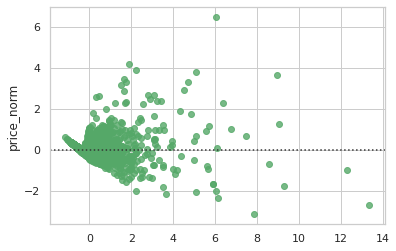

In [ ]:
#Como nossa predição é quantitativa, precisamos de algoritmos de regressão, vamos começar com o clássico de regressão linear

model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_val)
mse = sklearn.metrics.mean_squared_error(y_val, predict)
r2 = r2_score(y_val, predict)
error_MAE = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r2))
print("MSE:     {:.3f}".format(mse))
print("MAE:     {:.3f}".format(error_MAE))
sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [ ]:
#Agora vamos melhorar a taxa de erros da regressão linear utilizando o Optuna, buscando encontrar o melhor alpha como hiperparâmetro principal
def linearObjective(trial):
    alpha = trial.suggest_uniform('alpha', 0.0, 2.0)
    model = sklearn.linear_model.Lasso(alpha=alpha)
    with mlflow.start_run(experiment_id=experiment_id_LinearRegression) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)
      mlflow.log_param("alpha", str(alpha))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction='minimize')
study.optimize(linearObjective, n_trials=20)

print('Minimum mean squared error: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

[I 2020-11-16 14:44:09,958] A new study created in memory with name: no-name-81b0fe91-b27a-44d8-b15c-59012f88b7fd
[I 2020-11-16 14:44:10,039] Trial 0 finished with value: 0.8364138483048585 and parameters: {'alpha': 0.8879161200648835}. Best is trial 0 with value: 0.8364138483048585.
[I 2020-11-16 14:44:10,100] Trial 1 finished with value: 0.843625097770656 and parameters: {'alpha': 1.3845012406545425}. Best is trial 0 with value: 0.8364138483048585.
[I 2020-11-16 14:44:10,173] Trial 2 finished with value: 0.44407257891689256 and parameters: {'alpha': 0.5753722705583522}. Best is trial 2 with value: 0.44407257891689256.
[I 2020-11-16 14:44:10,252] Trial 3 finished with value: 0.843625097770656 and parameters: {'alpha': 0.8988975796264234}. Best is trial 2 with value: 0.44407257891689256.
[I 2020-11-16 14:44:10,313] Trial 4 finished with value: 0.6865384239671637 and parameters: {'alpha': 0.7856537786761786}. Best is trial 2 with value: 0.44407257891689256.
[I 2020-11-16 14:44:10,405] T

Minimum mean squared error: 0.1742334343855015
Best parameter: {'alpha': 0.05442649382138529}


R2:      0.970
MSE:     0.025
MAE:     0.050


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



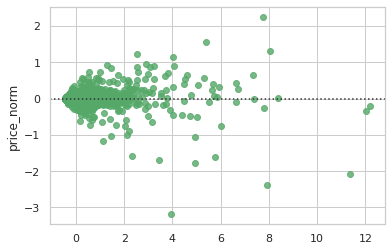

In [ ]:
#Agora vamos fazer o random Forest

model1  = RandomForestRegressor()
model1.fit(X_train, y_train)

predict = model1.predict(X_val)

mse1 = sklearn.metrics.mean_squared_error(y_val, predict)
r21 = r2_score(y_val, predict)
error_MAE1 = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r21))
print("MSE:     {:.3f}".format(mse1))
print("MAE:     {:.3f}".format(error_MAE1))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [ ]:
#Agora vamos minimizar a taxa de erros do Random Forest utilizando o optuna, focando no max_depth como hiper parâmetro a ser melhorado
def randomObjective(trial):
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    model = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth)
    with mlflow.start_run(experiment_id=experiment_id_RandomForest) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)
      mlflow.log_param("rf_max_depth", str(rf_max_depth))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE
study = optuna.create_study(direction="minimize")
study.optimize(randomObjective, n_trials=10)
print(study.best_trial)

[I 2020-11-16 14:44:14,815] A new study created in memory with name: no-name-3b81164d-5485-45eb-98e8-9ad045017327
[I 2020-11-16 14:44:15,904] Trial 0 finished with value: 0.02842905303983667 and parameters: {'rf_max_depth': 5}. Best is trial 0 with value: 0.02842905303983667.
[I 2020-11-16 14:44:16,980] Trial 1 finished with value: 0.028900023882442682 and parameters: {'rf_max_depth': 5}. Best is trial 0 with value: 0.02842905303983667.
[I 2020-11-16 14:44:20,046] Trial 2 finished with value: 0.023485980084145403 and parameters: {'rf_max_depth': 30}. Best is trial 2 with value: 0.023485980084145403.
[I 2020-11-16 14:44:22,364] Trial 3 finished with value: 0.023136348487956926 and parameters: {'rf_max_depth': 13}. Best is trial 3 with value: 0.023136348487956926.
[I 2020-11-16 14:44:25,431] Trial 4 finished with value: 0.023967567800574584 and parameters: {'rf_max_depth': 30}. Best is trial 3 with value: 0.023136348487956926.
[I 2020-11-16 14:44:28,469] Trial 5 finished with value: 0.02

FrozenTrial(number=7, value=0.022008824033188403, datetime_start=datetime.datetime(2020, 11, 16, 14, 44, 30, 483587), datetime_complete=datetime.datetime(2020, 11, 16, 14, 44, 32, 821634), params={'rf_max_depth': 13}, distributions={'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE)


R2:      0.921
MSE:     0.067
MAE:     0.095


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



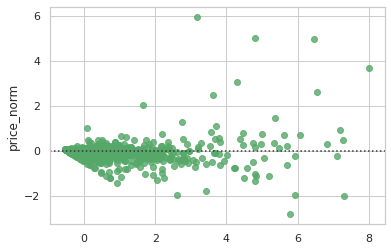

In [ ]:
#Agora vamos fazer o SVR

model2  = SVR()
model2.fit(X_train, y_train)

predict = model2.predict(X_val)

mse2 = sklearn.metrics.mean_squared_error(y_val, predict)
r22 = r2_score(y_val, predict)
error_MAE2 = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r22))
print("MSE:     {:.3f}".format(mse2))
print("MAE:     {:.3f}".format(error_MAE2))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [ ]:
#Agora vamos melhorar a acurácia do SVR no optuna, focando no C como hiperparâmetro a ser melhorado
def svrObjective(trial):
    svr_c = trial.suggest_loguniform('svr_c', 1e-3, 1e3)
    model = SVR(C=svr_c)
    with mlflow.start_run(experiment_id=experiment_id_SVR) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)
      mlflow.log_param("svr_c", str(svr_c))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction="minimize")
study.optimize(svrObjective, n_trials=10)
print(study.best_trial)

[I 2020-11-16 14:44:35,939] A new study created in memory with name: no-name-bcb380e8-c03b-4a88-9fdc-010c9defbcd4
[I 2020-11-16 14:44:37,732] Trial 0 finished with value: 0.38017482909655714 and parameters: {'svr_c': 0.01657173820872732}. Best is trial 0 with value: 0.38017482909655714.
[I 2020-11-16 14:44:39,764] Trial 1 finished with value: 0.04072073912555234 and parameters: {'svr_c': 2.693346461713296}. Best is trial 1 with value: 0.04072073912555234.
[I 2020-11-16 14:45:59,207] Trial 2 finished with value: 0.0545150406513219 and parameters: {'svr_c': 745.7140591332728}. Best is trial 1 with value: 0.04072073912555234.
[I 2020-11-16 14:46:01,998] Trial 3 finished with value: 0.5986694981951372 and parameters: {'svr_c': 0.0017823705700354571}. Best is trial 1 with value: 0.04072073912555234.
[I 2020-11-16 14:46:05,120] Trial 4 finished with value: 0.03271110905242708 and parameters: {'svr_c': 7.7435055523183}. Best is trial 4 with value: 0.03271110905242708.
[I 2020-11-16 14:46:07,8

FrozenTrial(number=4, value=0.03271110905242708, datetime_start=datetime.datetime(2020, 11, 16, 14, 46, 1, 999512), datetime_complete=datetime.datetime(2020, 11, 16, 14, 46, 5, 120373), params={'svr_c': 7.7435055523183}, distributions={'svr_c': LogUniformDistribution(high=1000.0, low=0.001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE)


R2:      0.965
MSE:     0.029
MAE:     0.071


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



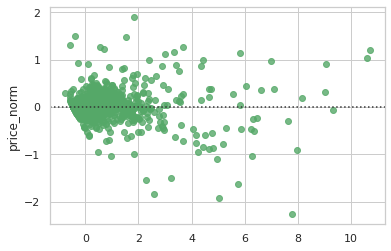

In [ ]:
#Agora vamos fazer o MLP

model3  = MLPRegressor()
model3.fit(X_train, y_train)

predict = model3.predict(X_val)

mse3 = sklearn.metrics.mean_squared_error(y_val, predict)
r23 = r2_score(y_val, predict)
error_MAE3 = sklearn.metrics.mean_absolute_error(y_val, predict)

print("R2:      {:.3f}".format(r23))
print("MSE:     {:.3f}".format(mse3))
print("MAE:     {:.3f}".format(error_MAE3))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

In [ ]:
#Agora vamos diminuir o erro do MLP no optuna, focando no número de camadas e perceptrons por camada como hiperparametros a serem melhorados
def mlpObjective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))
    with mlflow.start_run(experiment_id=experiment_id_MLP) as run:
      model = MLPRegressor(hidden_layer_sizes=tuple(layers))
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)
      mlflow.log_param("layers", str(layers))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction="minimize")
study.optimize(mlpObjective, n_trials=10)
print(study.best_trial)

[I 2020-11-16 14:48:38,679] A new study created in memory with name: no-name-eebf0bad-5680-4a1b-8db3-4278098ce18c
[I 2020-11-16 14:48:45,274] Trial 0 finished with value: 0.032306440775398036 and parameters: {'n_layers': 1, 'n_units_0': 99}. Best is trial 0 with value: 0.032306440775398036.
[I 2020-11-16 14:48:50,287] Trial 1 finished with value: 0.03397497867881011 and parameters: {'n_layers': 2, 'n_units_0': 94, 'n_units_1': 3}. Best is trial 0 with value: 0.032306440775398036.
[I 2020-11-16 14:48:55,743] Trial 2 finished with value: 0.03283115989664889 and parameters: {'n_layers': 2, 'n_units_0': 73, 'n_units_1': 87}. Best is trial 0 with value: 0.032306440775398036.
[I 2020-11-16 14:48:58,586] Trial 3 finished with value: 0.0378997001296035 and parameters: {'n_layers': 1, 'n_units_0': 44}. Best is trial 0 with value: 0.032306440775398036.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum i

FrozenTrial(number=9, value=0.027135083107092284, datetime_start=datetime.datetime(2020, 11, 16, 14, 49, 22, 368765), datetime_complete=datetime.datetime(2020, 11, 16, 14, 49, 31, 598765), params={'n_layers': 3, 'n_units_0': 24, 'n_units_1': 83, 'n_units_2': 3}, distributions={'n_layers': IntUniformDistribution(high=4, low=1, step=1), 'n_units_0': IntUniformDistribution(high=100, low=1, step=1), 'n_units_1': IntUniformDistribution(high=100, low=1, step=1), 'n_units_2': IntUniformDistribution(high=100, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=9, state=TrialState.COMPLETE)


**Agora vamos começar a utilizar os grupos de teste para começar a diagnosticar melhor os algoritmos**

R2:      0.766
MSE:     0.215
MAE:     0.224


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



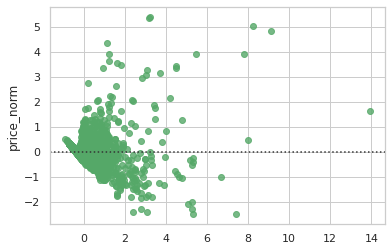

In [ ]:
#Linear Regression TEST

model = sklearn.linear_model.Lasso(alpha=0.09772485691726618)
model.fit(X_train, y_train)
predict = model.predict(X_test)
mse = sklearn.metrics.mean_squared_error(y_test, predict)
r2 = r2_score(y_test, predict)
error_MAE = sklearn.metrics.mean_absolute_error(y_test, predict)

print("R2:      {:.3f}".format(r2))
print("MSE:     {:.3f}".format(mse))
print("MAE:     {:.3f}".format(error_MAE))
sns.set(style="whitegrid")
sns.residplot(predict, y_test, color="g")


R2:      0.953
MSE:     0.043
MAE:     0.068


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



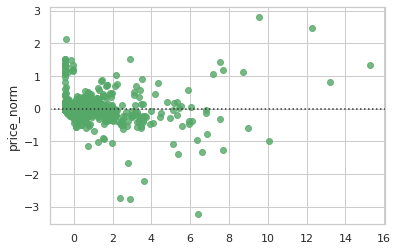

In [ ]:
#RandomForest TEST
model1  = RandomForestRegressor(max_depth=9)
model1.fit(X_train, y_train)
predict = model1.predict(X_test)

mse1 = sklearn.metrics.mean_squared_error(y_test, predict)
r21 = r2_score(y_test, predict)
error_MAE1 = sklearn.metrics.mean_absolute_error(y_test, predict)

print("R2:      {:.3f}".format(r21))
print("MSE:     {:.3f}".format(mse1))
print("MAE:     {:.3f}".format(error_MAE1))

sns.set(style="whitegrid")
sns.residplot(predict, y_test, color="g")

R2:      0.954
MSE:     0.042
MAE:     0.091


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



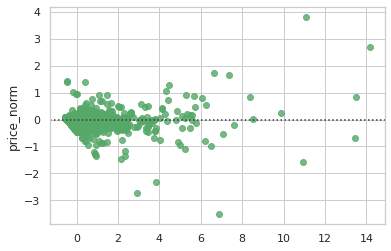

In [ ]:
#SVR TEST

model2  = SVR(C=13.648886813005916)
model2.fit(X_train, y_train)

predict = model2.predict(X_test)

mse2 = sklearn.metrics.mean_squared_error(y_test, predict)
r22 = r2_score(y_test, predict)
error_MAE2 = sklearn.metrics.mean_absolute_error(y_test, predict)

print("R2:      {:.3f}".format(r22))
print("MSE:     {:.3f}".format(mse2))
print("MAE:     {:.3f}".format(error_MAE2))

sns.set(style="whitegrid")
sns.residplot(predict, y_test, color="g")

R2:      0.937
MSE:     0.058
MAE:     0.081


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



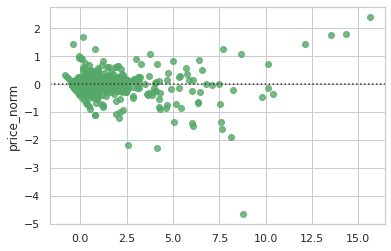

In [ ]:
#MLP TEST

model3  = MLPRegressor(hidden_layer_sizes=tuple([55, 61]))
model3.fit(X_train, y_train)

predict = model3.predict(X_test)

mse3 = sklearn.metrics.mean_squared_error(y_test, predict)
r23 = r2_score(y_test, predict)
error_MAE3 = sklearn.metrics.mean_absolute_error(y_test, predict)

print("R2:      {:.3f}".format(r23))
print("MSE:     {:.3f}".format(mse3))
print("MAE:     {:.3f}".format(error_MAE3))

sns.set(style="whitegrid")
sns.residplot(predict, y_test, color="g")

O **SVR** se mostrou um algoritmo mais generalista do que os outros, tendo uma menor diferença no que se refere ao root mean squared error quando usamos a base de testes.

Assim demonstrando uma menor tendência a overfitting para a nossa base de dados e mantendo bons resultados do R2. Vendo isso, optamos por tentar melhorar ele utilizando o optuna

In [ ]:
#Testamos mudanças no kernel do SVR e o rbf que é o padrão se manteve como melhor

#Testando a ordem de grandeza do c e do gamma

def svrObjective(trial):
    svr_c = trial.suggest_categorical('svr_c',  [0.01, 0.1, 1, 10, 100])
    gamma = trial.suggest_categorical('gamma', [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9])
    model = SVR(C=svr_c,gamma=gamma)
    with mlflow.start_run(experiment_id=experiment_id_SVR) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)
      mlflow.log_param("svr_c", str(svr_c))
      mlflow.log_param("gamma", str(gamma))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MSE

study = optuna.create_study(direction="minimize")
study.optimize(svrObjective, n_trials=50)
print(study.best_trial)

[I 2020-11-16 14:49:43,673] A new study created in memory with name: no-name-bb2efcc6-a850-44dd-ba2a-7b7feb4d8f0b
[I 2020-11-16 14:50:07,662] Trial 0 finished with value: 0.0568409516472318 and parameters: {'svr_c': 100, 'gamma': 0.5}. Best is trial 0 with value: 0.0568409516472318.
[I 2020-11-16 14:50:09,224] Trial 1 finished with value: 0.15968406646725378 and parameters: {'svr_c': 0.1, 'gamma': 0.1}. Best is trial 0 with value: 0.0568409516472318.
[I 2020-11-16 14:50:11,147] Trial 2 finished with value: 0.11189920005622551 and parameters: {'svr_c': 1, 'gamma': 0.5}. Best is trial 0 with value: 0.0568409516472318.
[I 2020-11-16 14:50:13,418] Trial 3 finished with value: 0.03497949690088808 and parameters: {'svr_c': 10, 'gamma': 0.01}. Best is trial 3 with value: 0.03497949690088808.
[I 2020-11-16 14:50:37,279] Trial 4 finished with value: 0.0568409516472318 and parameters: {'svr_c': 100, 'gamma': 0.5}. Best is trial 3 with value: 0.03497949690088808.
[I 2020-11-16 14:50:39,508] Trial

FrozenTrial(number=27, value=0.030293764296803943, datetime_start=datetime.datetime(2020, 11, 16, 14, 51, 56, 691110), datetime_complete=datetime.datetime(2020, 11, 16, 14, 51, 59, 737270), params={'svr_c': 10, 'gamma': 0.1}, distributions={'svr_c': CategoricalDistribution(choices=(0.01, 0.1, 1, 10, 100)), 'gamma': CategoricalDistribution(choices=(0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=27, state=TrialState.COMPLETE)


Para refinar o SVR pensamos da seguinte maneira: já que tanto o C quando o Gamma, que foram os hiperparâmetros escolhidos, possuem um range bastante grande de possibilidades, vamos primeiro buscar uma ordem de grandeza que valha a pena.
Na etapa anterior, como pode ser vistos, passamos um vetor com valores pulando algumas ordens de grandeza. Após os testes, vimos que a ordem de grandeza do **C foi 10 e o gamma 0.1**, aí colocamos mais um range dentro dessa ordem de grandeza para refinar.

In [ ]:
#refinamento do c e do gamma
def svrObjective(trial):
    svr_c = trial.suggest_uniform('svr_c', 5.0, 50.0)
    gamma = trial.suggest_uniform('gamma', 0.05, 0.2)
    model = SVR(C=svr_c,gamma=gamma)
    with mlflow.start_run(experiment_id=experiment_id_SVR) as run:
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
      error_MSE = sklearn.metrics.mean_squared_error(y_val, y_pred)
      error_MAE = sklearn.metrics.mean_absolute_error(y_val, y_pred)
      r2 = r2_score(y_val, y_pred)
      mlflow.log_param("svr_c", str(svr_c))
      mlflow.log_param("gamma", str(gamma))
      mlflow.log_metric('mean_squared_error', error_MSE)
      mlflow.log_metric('mean_absolute_error', error_MAE)
      mlflow.log_metric('r2_score', r2)
      mlflow.end_run()
    return error_MAE

study = optuna.create_study(direction="minimize")
study.optimize(svrObjective, n_trials=50)
print(study.best_trial)

[I 2020-11-16 15:18:59,166] A new study created in memory with name: no-name-40022c74-6959-4459-a75f-2e09a5244a3f
[I 2020-11-16 15:19:04,232] Trial 0 finished with value: 0.08282531449110672 and parameters: {'svr_c': 20.086947843367362, 'gamma': 0.19643399294894837}. Best is trial 0 with value: 0.08282531449110672.
[I 2020-11-16 15:19:09,493] Trial 1 finished with value: 0.08128301452386578 and parameters: {'svr_c': 24.58860775746197, 'gamma': 0.16710975177637968}. Best is trial 1 with value: 0.08128301452386578.
[I 2020-11-16 15:19:13,352] Trial 2 finished with value: 0.07833083581668138 and parameters: {'svr_c': 19.03416728767929, 'gamma': 0.09411378510799871}. Best is trial 2 with value: 0.07833083581668138.
[I 2020-11-16 15:19:16,176] Trial 3 finished with value: 0.082046160623731 and parameters: {'svr_c': 7.391565264227317, 'gamma': 0.15505158136536507}. Best is trial 2 with value: 0.07833083581668138.
[I 2020-11-16 15:19:23,972] Trial 4 finished with value: 0.08305493702975926 an

FrozenTrial(number=7, value=0.07687631414802118, datetime_start=datetime.datetime(2020, 11, 16, 15, 19, 35, 371745), datetime_complete=datetime.datetime(2020, 11, 16, 15, 19, 40, 821279), params={'svr_c': 31.314177808377032, 'gamma': 0.10906356128893395}, distributions={'svr_c': UniformDistribution(high=50.0, low=5.0), 'gamma': UniformDistribution(high=0.2, low=0.05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE)


E para finalizar, testamos no conjunto de testes com os parametros novos e tivemos uma pequena melhora como pode ser visto no **próximo bloco**

Sendo assim, dentro do quanto rodamos e treinamos os algoritmos, o **SVR** se mostrou o melhor para nossa base, se mantendo estável entre o treinamento e os testes. Enquanto isso, outros algoritmos quando foram pros testes decaíram consideravelmente mais que ele, demonstrando overfitting em alguns casos como o MLP, por exemplo.


R2:      0.960
MSE:     0.037
MAE:     0.085


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



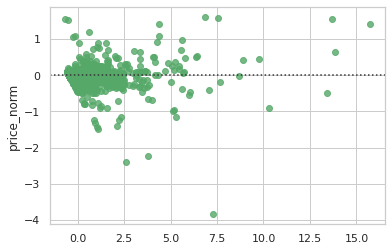

In [ ]:

model2  = SVR(C=31.314177808377032,gamma=0.10906356128893395)
model2.fit(X_train, y_train)

predict = model2.predict(X_test)

mse2 = sklearn.metrics.mean_squared_error(y_test, predict)
r22 = r2_score(y_test, predict)
error_MAE2 = sklearn.metrics.mean_absolute_error(y_test, predict)

print("R2:      {:.3f}".format(r22))
print("MSE:     {:.3f}".format(mse2))
print("MAE:     {:.3f}".format(error_MAE2))

sns.set(style="whitegrid")
sns.residplot(predict, y_test, color="g")